In [1]:
import os, sys
os.environ['ON_PY']="1"
from params import parser
from common_utils import setup_seed
from data_utils import pack_data_from_config
import numpy as np
from test_script.base import Test
import matplotlib.pyplot as plt
import numpy as np

notebook_dir = os.getcwd()
print(notebook_dir)
# 将工作目录更改为上一级目录
os.chdir("/home/wlc/FJSP-DRL-MAML")



(CVXPY) Feb 02 01:40:09 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 02 01:40:09 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


/home/wlc/miniconda3/envs/RL-torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/wlc/miniconda3/envs/RL-torch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


/home/wlc/FJSP-DRL-MAML/plot_imgs


In [2]:
instances = ["10x5+mix", "20x5+mix", "15x10+mix", "20x10+mix",]

plot_dict = {}
for key in instances:
    plot_dict[key] = [np.array(11) for _ in range(4)]

plot_dict

{'10x5+mix': [array(11), array(11), array(11), array(11)],
 '20x5+mix': [array(11), array(11), array(11), array(11)],
 '15x10+mix': [array(11), array(11), array(11), array(11)],
 '20x10+mix': [array(11), array(11), array(11), array(11)]}

In [ ]:
# 数学解



In [3]:
# DAN 解

args = ["--test_data", "10x5+mix", "20x5+mix", "15x10+mix", "20x10+mix",
        "--test_model", "10x5x10+mix","20x5x10+mix", "15x10x10+mix", "20x10x10+mix"]
configs = parser.parse_args(args=args)

setup_seed(configs.seed_test)


test_model = []

for model_name in configs.test_model:
    test_model.append((f'./trained_network/{configs.model_source}/{model_name}.pth', model_name))
print(test_model)
test_data = pack_data_from_config(configs.data_source, configs.test_data)

print(os.getcwd())
baseline_makespans = []
for i in range(len(test_model)):
    model = test_model[i]
    data = test_data[i]
    print("datta[1]: ",data[1])
    print("-" * 25 + "Test Learned Model" + "-" * 25)
    print(f"test data name: {data[1]}")
    finetuning = True if model[1].startswith("maml") else False
    print(f"Model name : {model[1]}")
    result_5_times = []
    for j in range(2):
        test = Test(configs, data[0], model[0])
        result = test.greedy_strategy(finetuning=finetuning)
        # result = test_greedy_strategy(data[0], model[0], config.seed_test)
        
        result_5_times.append(result)
    result_5_times = np.array(result_5_times)

    save_result = np.mean(result_5_times, axis=0)
    print("testing results:")
    print(f"makespan(greedy): ", save_result[:, 0].mean())
    baseline_makespans.append(save_result[:, 0].mean())
    print(f"time: ", save_result[:, 1].mean())
    # print(f"Max fast_adapt cnt:", save_result[:, 2].max())
    # print(f"Average fast_adapt time:", save_result[:, 3].mean())
    print("="*100)

print(baseline_makespans)




[('./trained_network/SD2/10x5x10+mix.pth', '10x5x10+mix'), ('./trained_network/SD2/20x5x10+mix.pth', '20x5x10+mix'), ('./trained_network/SD2/15x10x10+mix.pth', '15x10x10+mix'), ('./trained_network/SD2/20x10x10+mix.pth', '20x10x10+mix')]
/home/wlc/FJSP-DRL-MAML
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : 10x5x10+mix
testing results:
makespan(greedy):  426.7
time:  0.3071696639060974
datta[1]:  20x5+mix
-------------------------Test Learned Model-------------------------
test data name: 20x5+mix
Model name : 20x5x10+mix
testing results:
makespan(greedy):  695.8
time:  0.5830219626426697
datta[1]:  15x10+mix
-------------------------Test Learned Model-------------------------
test data name: 15x10+mix
Model name : 15x10x10+mix
testing results:
makespan(greedy):  570.9
time:  0.878282618522644
datta[1]:  20x10+mix
-------------------------Test Learned Model-------------------------
test data name: 20x10+mix


In [4]:
# MAML finetuning
# 获取finetuning的每个过程

def MAML_finetuning_test(args):
    configs = parser.parse_args(args=args)
    print(configs.hidden_dim_actor, configs.hidden_dim_critic)
    test_model = []

    for model_name in configs.test_model:
        test_model.append((f'./trained_network/{configs.model_source}/{model_name}.pth', model_name))
    print(test_model)

    model = test_model[0]

    test_data = pack_data_from_config(configs.data_source, configs.test_data)
    makespans = []
    finetuning_makespans = []
    for data in test_data:
        print("datta[1]: ",data[1])
        print("-" * 25 + "Test Learned Model" + "-" * 25)
        print(f"test data name: {data[1]}")
        if model[1].startswith("maml"): finetuning = True
        print(f"Model name : {model[1]}")
        result_5_times = []
        test = Test(configs, data[0], model[0])
        result = test.finetuning()
        finetuning_makespans.append(result)
        # result = test_greedy_strategy(data[0], model[0], config.seed_test)
        # print(result)
        for j in range(2):
            result = test.greedy_strategy()
            result_5_times.append(result)
        result_5_times = np.array(result_5_times)

        save_result = np.mean(result_5_times, axis=0)
        print("testing results:")
        print(f"makespan(greedy): ", save_result[:, 0].mean())
        makespans.append(save_result[:, 0].mean())
        print(f"time: ", save_result[:, 1].mean())
        # print(f"Max fast_adapt cnt:", save_result[:, 2].max())
        # print(f"Average fast_adapt time:", save_result[:, 3].mean())
        print("="*100)

    return makespans, finetuning_makespans



In [5]:
args = ["--test_data", "10x5+mix", "20x5+mix", "15x10+mix", "20x10+mix",
        #  "--hidden_dim_actor", "512", "--hidden_dim_critic", "512", 
        "--test_model", "maml+EXP19"]

maml_makespans, maml_finetuning_makespans = MAML_finetuning_test(args)
print(maml_makespans)
print(maml_finetuning_makespans)



64 64
[('./trained_network/SD2/maml+EXP19.pth', 'maml+EXP19')]
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : maml+EXP19
testing results:
makespan(greedy):  521.7
time:  0.28811217546463014
datta[1]:  20x5+mix
-------------------------Test Learned Model-------------------------
test data name: 20x5+mix
Model name : maml+EXP19
testing results:
makespan(greedy):  810.3
time:  0.5824862360954285
datta[1]:  15x10+mix
-------------------------Test Learned Model-------------------------
test data name: 15x10+mix
Model name : maml+EXP19
testing results:
makespan(greedy):  666.9
time:  0.8855155348777771
datta[1]:  20x10+mix
-------------------------Test Learned Model-------------------------
test data name: 20x10+mix
Model name : maml+EXP19
testing results:
makespan(greedy):  805.2
time:  1.203652596473694
[521.7, 810.3, 666.9, 805.2]
[array([553.6, 534.8, 544.6, 542.3, 537.8, 566.4, 518.6, 559.5, 544.4,
       54

In [5]:
args = ["--test_data", "10x5+mix", "20x5+mix", "15x10+mix", "20x10+mix", 
        "--hidden_dim_actor", "512", "--hidden_dim_critic", "512",
        "--test_model", "maml+exp18-10"]

maml_makespans, maml_finetuning_makespans = MAML_finetuning_test(args)
print(maml_makespans)
print(maml_finetuning_makespans)


512 512
[('./trained_network/SD2/maml+exp18-10.pth', 'maml+exp18-10')]
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : maml+exp18-10
testing results:
makespan(greedy):  467.1
time:  0.2953647971153259
datta[1]:  20x5+mix
-------------------------Test Learned Model-------------------------
test data name: 20x5+mix
Model name : maml+exp18-10
testing results:
makespan(greedy):  726.4
time:  0.6065203785896301
datta[1]:  15x10+mix
-------------------------Test Learned Model-------------------------
test data name: 15x10+mix
Model name : maml+exp18-10
testing results:
makespan(greedy):  662.8
time:  0.9170003533363342
datta[1]:  20x10+mix
-------------------------Test Learned Model-------------------------
test data name: 20x10+mix
Model name : maml+exp18-10


In [6]:
args = ["--test_data", "10x5+mix", "20x5+mix", "15x10+mix", "20x10+mix", 
        "--hidden_dim_actor", "512", "--hidden_dim_critic", "512",
        "--test_model", "maml+exp18-9"]

maml_makespans, maml_finetuning_makespans = MAML_finetuning_test(args)
print(maml_makespans)
print(maml_finetuning_makespans)

512 512
[('./trained_network/SD2/maml+exp18-9.pth', 'maml+exp18-9')]
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : maml+exp18-9
testing results:
makespan(greedy):  446.8
time:  0.29171247482299806
datta[1]:  20x5+mix
-------------------------Test Learned Model-------------------------
test data name: 20x5+mix
Model name : maml+exp18-9
testing results:
makespan(greedy):  721.4
time:  0.5910425662994385
datta[1]:  15x10+mix
-------------------------Test Learned Model-------------------------
test data name: 15x10+mix
Model name : maml+exp18-9
testing results:
makespan(greedy):  640.6
time:  0.8905350685119628
datta[1]:  20x10+mix
-------------------------Test Learned Model-------------------------
test data name: 20x10+mix
Model name : maml+exp18-9
testing results:
makespan(greedy):  723.1
time:  1.209375524520874
[446.8, 721.4, 640.6, 723.1]
[array([462.1, 460.3, 480.2, 459.2, 454.1, 453.1, 469.9, 462.6, 44

In [7]:
# pretrain finetuning

args = ["--test_data", "10x5+mix", "20x5+mix", "15x10+mix", "20x10+mix", 
        "--hidden_dim_actor", "512", "--hidden_dim_critic", "512",
        "--test_model", "maml+EXP19pre_train"]

pre_train_makespans, pre_train_finetuning_makespans = MAML_finetuning_test(args)


print(plot_dict)

512 512
[('./trained_network/SD2/maml+EXP19pre_train.pth', 'maml+EXP19pre_train')]
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : maml+EXP19pre_train
testing results:
makespan(greedy):  436.6
time:  0.2958407998085022
datta[1]:  20x5+mix
-------------------------Test Learned Model-------------------------
test data name: 20x5+mix
Model name : maml+EXP19pre_train
testing results:
makespan(greedy):  704.4
time:  0.5976510167121887
datta[1]:  15x10+mix
-------------------------Test Learned Model-------------------------
test data name: 15x10+mix
Model name : maml+EXP19pre_train
testing results:
makespan(greedy):  612.8
time:  0.9008393883705139
datta[1]:  20x10+mix
-------------------------Test Learned Model-------------------------
test data name: 20x10+mix
Model name : maml+EXP19pre_train
testing results:
makespan(greedy):  679.6
time:  1.231838047504425
{'10x5+mix': [array(11), array(11), array(11), array(1

In [9]:
# random
import torch
from model.PPO import PPO_initialize

ppo = PPO_initialize(configs)

torch.save(ppo.policy.state_dict(), f'./trained_network/SD2/test_random.pth')

args = ["--test_data", "10x5+mix", "20x5+mix", "15x10+mix", "20x10+mix", 
        "--test_model", "test_random"]

random_makespans, random_finetuning_makespans = MAML_finetuning_test(args)






64 64
[('./trained_network/SD2/test_random.pth', 'test_random')]
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : test_random
testing results:
makespan(greedy):  627.9
time:  0.2896632432937622
datta[1]:  20x5+mix
-------------------------Test Learned Model-------------------------
test data name: 20x5+mix
Model name : test_random
testing results:
makespan(greedy):  1174.8
time:  0.5885154604911804
datta[1]:  15x10+mix
-------------------------Test Learned Model-------------------------
test data name: 15x10+mix
Model name : test_random
testing results:
makespan(greedy):  943.8
time:  0.8962715268135071
datta[1]:  20x10+mix
-------------------------Test Learned Model-------------------------
test data name: 20x10+mix
Model name : test_random
testing results:
makespan(greedy):  1215.7
time:  1.2151592254638672


[[593.1, 568.3, 570.1, 589.2, 567.0, 562.1, 588.8, 594.0, 584.3, 581.0, 584.8, 554.5, 564.1, 574.7, 550.8, 535.8, 568.3, 557.6, 553.4, 588.1, 556.5, 548.5, 566.7, 538.7, 593.7, 574.6, 540.2, 550.6, 556.8, 584.9, 553.8, 549.5, 534.0, 579.3, 546.9, 545.2, 537.2, 565.8, 503.1, 540.8, 526.5, 566.6, 517.0, 543.4, 519.3, 549.0, 524.9, 514.1, 492.6, 487.1, 514.8, 492.5, 499.6, 507.4, 499.6, 514.3, 522.7, 499.0, 485.3, 473.1, 469.1, 488.1, 482.8, 489.5, 489.5, 489.2, 501.7, 479.5, 473.6, 501.9, 492.1, 477.8, 439.5, 499.9, 446.6, 464.0, 475.4, 476.8, 461.0, 468.0, 442.1, 446.5, 455.6, 455.8, 436.6, 465.6, 408.4, 445.5, 439.4, 404.3, 438.5, 392.5, 467.1, 419.2, 421.0, 416.0, 396.8, 449.6, 436.8, 382.2, 418.3, 425.0, 419.9, 438.2, 435.7, 443.0, 417.9, 400.3, 422.6, 400.6, 395.2, 430.6, 379.7, 398.2, 383.9, 397.0, 365.6, 369.8, 387.4, 373.9, 363.0, 376.5, 370.1, 335.5, 354.6, 340.4, 371.1, 364.5, 336.5, 376.4, 388.6, 358.0, 368.0, 334.1, 353.2, 346.7, 351.5, 338.9, 318.4, 335.3, 388.4, 375.7, 362.

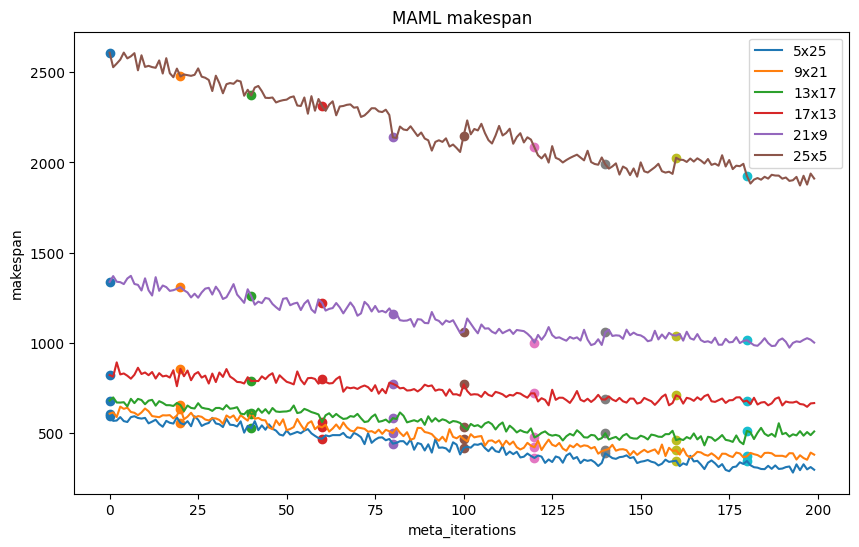

In [5]:
# maml makespan 变化
with open("./train_log/makespans.txt", "r") as f:
    makespans = eval(f.read())

print(makespans)
import matplotlib.pyplot as plt
import numpy as np

# 假设这是你的6xN的二维张量（这里用随机数据代替）
# 假设N=10
N = 10
data = np.array(makespans)

# 创建一个折线图
instances = ['5x25', '9x21', '13x17', '17x13', '21x9', '25x5']
plt.figure(figsize=(10, 6))
for i in range(data.shape[0]):
    plt.plot(data[i, :], label=f'{instances[i]}')
    for pos in range(len(data[0])):
        if pos % 20 == 0:
            plt.scatter(pos, data[i, pos], marker='o')

# 添加图例
plt.legend()

# 添加标题和轴标签
plt.title("MAML makespan")
plt.xlabel("meta_iterations")
plt.ylabel("makespan")

# 显示图表
plt.show()


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for the 2D array (4 rows, 11 columns)

def plot_makespan(data):
    # Labels for the lines
    labels = ["DAN_baseline", "MAML", "pre_training", "random"]

    # Plotting the lines
    for i, row in enumerate(data):
        plt.plot(row, label=labels[i])
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title("Line Plots for Each Row in the 2D Array")
    plt.legend()
    plt.show()



{'10x5+mix': [array([426.7, 426.7, 426.7, 426.7, 426.7, 426.7, 426.7, 426.7, 426.7,
       426.7, 426.7]), array([553.6, 534.8, 544.6, 542.3, 537.8, 566.4, 518.6, 559.5, 544.4,
       546.1, 531. ]), array([453.6, 450.8, 447.4, 446.6, 458.2, 451.6, 445.7, 461.6, 452.1,
       443.8, 449.2]), array([632.1, 612.4, 642.1, 619.6, 635.1, 626.8, 651. , 620. , 657.6,
       647.8, 658.1])], '20x5+mix': [array([695.8, 695.8, 695.8, 695.8, 695.8, 695.8, 695.8, 695.8, 695.8,
       695.8, 695.8]), array([884.7, 901.4, 913.2, 885.5, 908.6, 879.5, 895.1, 900.7, 867. ,
       874.4, 878.4]), array([722.8, 704.9, 723.6, 717. , 716.7, 732. , 698.1, 712.2, 728.8,
       705. , 707.1]), array([1154.4, 1152. , 1175.9, 1129.6, 1158.1, 1154.2, 1143.9, 1119.6,
       1135.5, 1118.7, 1146.5])], '15x10+mix': [array([570.9, 570.9, 570.9, 570.9, 570.9, 570.9, 570.9, 570.9, 570.9,
       570.9, 570.9]), array([772.4, 763.4, 769.7, 725.4, 762.6, 765.6, 753. , 765.4, 750.1,
       777.9, 758. ]), array([635.7, 64

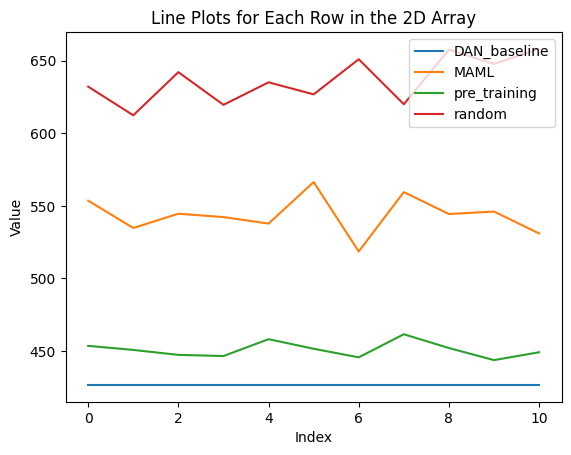

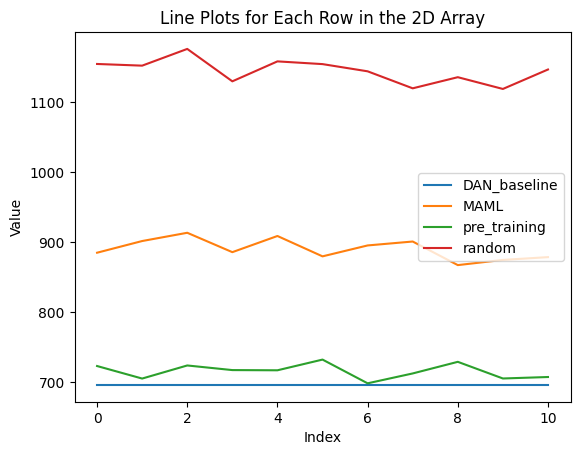

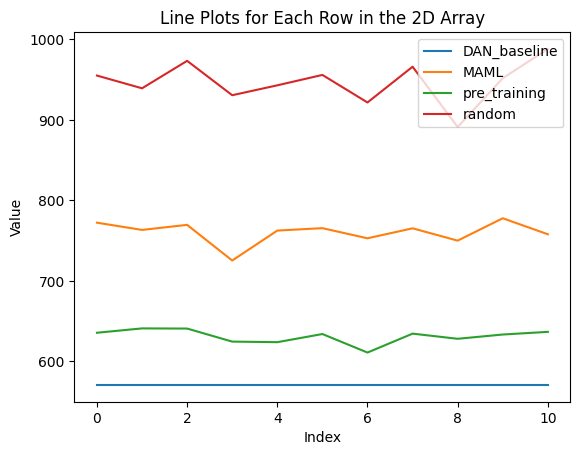

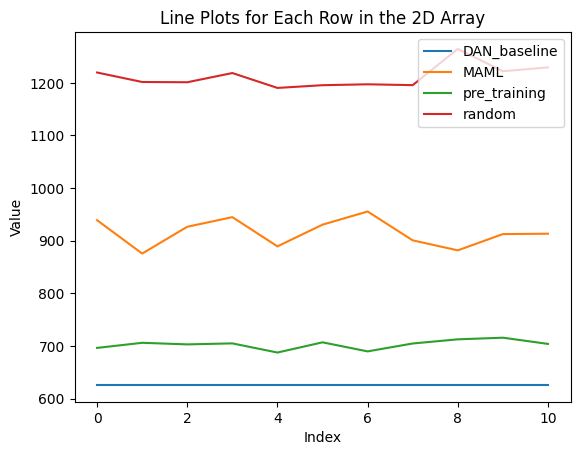

In [12]:

for idx, key in enumerate(instances):
    # plot_dict[key][0] = [baseline_makespans[idx]  for _ in range(configs.adapt_nums)]
    plot_dict[key][0] = np.full(configs.adapt_nums, baseline_makespans[idx])
    plot_dict[key][1] = maml_finetuning_makespans[idx]
    plot_dict[key][2] = pre_train_finetuning_makespans[idx]
    plot_dict[key][3] = random_finetuning_makespans[idx]

print(plot_dict)

for key in instances:
    data = plot_dict[key]
    plot_makespan(data)